# CS 39AA - Airline Tweets w/ Pre-trained Word Embeddings

We've started talking about word embeddings; what they are as well as how we both create and use them. We'll now see what it looks like to load and use pre-made embeddings on the Airline Tweet dataset. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_notebooks/blob/main/nb_C_airline_tweets_take2.ipynb)



In [191]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import pairwise_cosine_similarity

Note that the following cell is going to download all of the GloVe word embeddings, which is approximately one gigabyte. There are different versions of GloVe with some having 300-element embeddings (so approximately 6 gigabytes!). Fortunately, this is saved locally (in a hidden directory called, _.vector_cache_), so if you run it again you will not have to wait for download each time. 

In [2]:
import torchtext as text
vec = text.vocab.GloVe(name='6B', dim=50)

Let's look at a few embeddings for some words that are related to airlines or travel. 

In [3]:
examples = ['disappointed', 'delay', 'happy', 'relieved', 'pilot', 'crew', 'suitcase', 'flight']
embeddings = vec.get_vecs_by_tokens(examples, lower_case_backup=True)
embeddings

tensor([[-2.2685e-02, -8.5923e-01,  4.9477e-02, -1.7606e-01,  6.4941e-01,
         -5.4191e-01, -5.5731e-01,  1.2037e+00, -7.9421e-01,  3.2672e-01,
          1.3117e-01, -6.6106e-03, -6.7498e-01, -5.3080e-01,  9.8269e-01,
          6.5216e-01,  4.1866e-01, -2.6490e-01,  8.6192e-02, -8.9927e-01,
         -6.6251e-01,  7.0842e-01,  1.0279e-01,  3.7234e-02,  1.2416e+00,
         -1.3999e+00, -3.4743e-01,  5.8947e-01, -2.4608e-01, -5.8111e-02,
          1.6744e+00,  5.8394e-01,  5.6990e-01, -2.6174e-01, -3.3512e-01,
         -1.2532e+00,  4.4094e-01,  2.2765e-01, -3.4198e-01, -1.0227e+00,
         -3.9604e-01, -3.1511e-01,  3.5769e-03,  1.5152e-01,  3.8344e-01,
          3.9369e-01, -1.0501e+00,  6.9915e-01, -7.8364e-04,  6.0356e-01],
        [ 9.0459e-01, -3.7000e-01,  2.0705e-01,  2.5889e-01, -7.2087e-01,
          7.0408e-01,  1.0693e-01,  1.1472e+00,  5.0695e-01,  6.4533e-02,
         -7.7592e-01, -1.0747e-01, -3.6821e-01,  5.2028e-02,  8.2169e-01,
          1.8539e-01, -3.7058e-01, -9

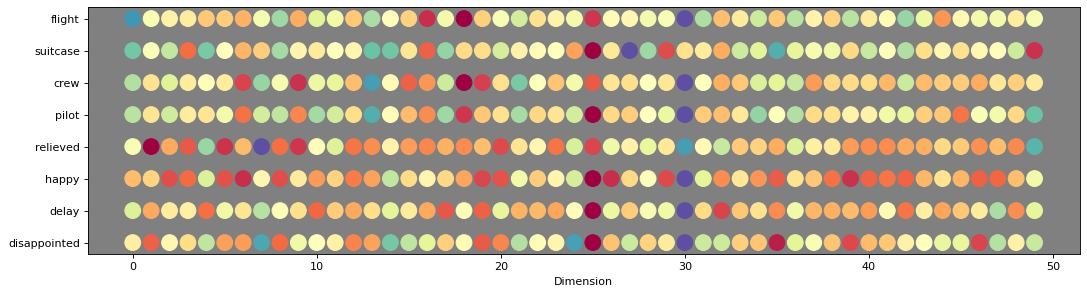

In [4]:
def compare_words_with_colors(vecs, wds):
    wdsr = wds[:]
    wdsr.reverse()
        
    dim = len(vecs[0])
    
    fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')
    
    for i,v in enumerate(vecs):
        ax.scatter(range(dim),[i]*dim, c=vecs[i], cmap='Spectral', s=200)
    
    #plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)
    
    plt.show()

compare_words_with_colors(embeddings, examples)
#examples.reverse()

In [5]:
similarities = pairwise_cosine_similarity(embeddings, zero_diagonal=False)
distances = 1 - similarities 
distances

pairwise_top = pd.DataFrame(
    distances,
    columns = examples,
    index = examples
)

distances
#similarities


tensor([[ 0.0000e+00,  5.7919e-01,  2.3252e-01,  3.5181e-01,  7.4722e-01,
          6.9937e-01,  1.0674e+00,  7.9178e-01],
        [ 5.7919e-01,  1.1921e-07,  6.5655e-01,  6.4911e-01,  5.3652e-01,
          6.4751e-01,  9.8461e-01,  5.2534e-01],
        [ 2.3252e-01,  6.5655e-01, -1.1921e-07,  4.5530e-01,  6.6121e-01,
          5.9392e-01,  8.8221e-01,  6.9901e-01],
        [ 3.5181e-01,  6.4911e-01,  4.5530e-01,  1.1921e-07,  5.8069e-01,
          5.4557e-01,  1.0651e+00,  6.6524e-01],
        [ 7.4722e-01,  5.3652e-01,  6.6121e-01,  5.8069e-01, -1.1921e-07,
          1.4877e-01,  7.2720e-01,  2.1097e-01],
        [ 6.9937e-01,  6.4751e-01,  5.9392e-01,  5.4557e-01,  1.4877e-01,
         -2.3842e-07,  6.2210e-01,  2.3664e-01],
        [ 1.0674e+00,  9.8461e-01,  8.8221e-01,  1.0651e+00,  7.2720e-01,
          6.2210e-01,  2.3842e-07,  6.7059e-01],
        [ 7.9178e-01,  5.2534e-01,  6.9901e-01,  6.6524e-01,  2.1097e-01,
          2.3664e-01,  6.7059e-01,  0.0000e+00]])

<AxesSubplot: >

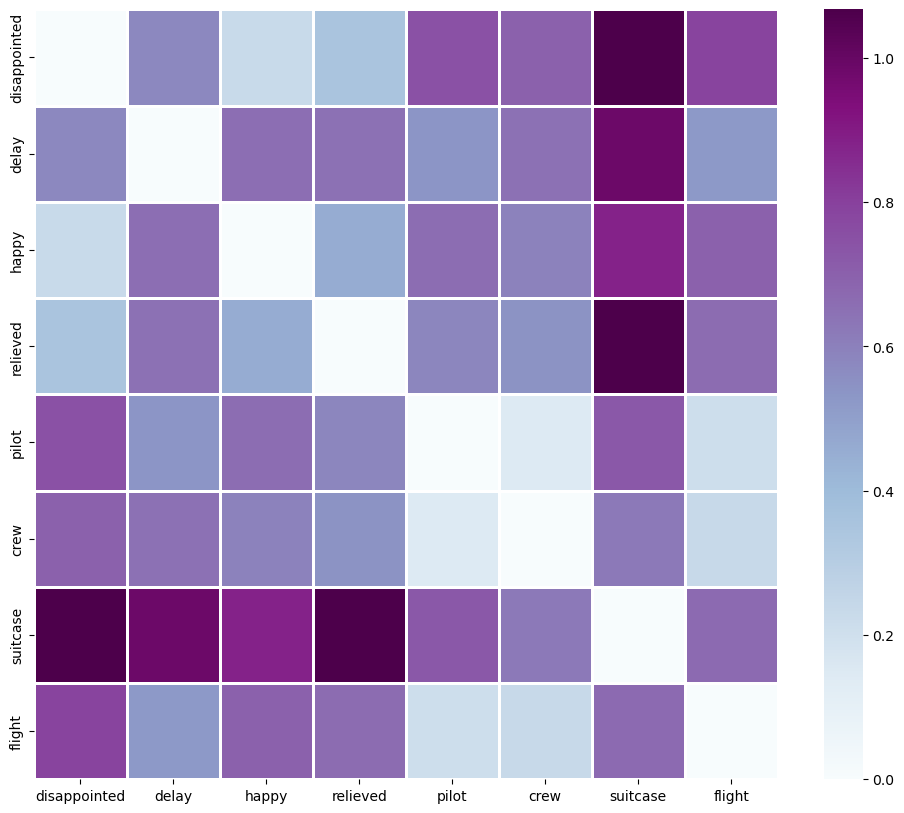

In [6]:
plt.figure(figsize=(12,10))
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("mako", as_cmap=True)
sns.heatmap(
    pairwise_top,
    cmap='BuPu', #'OrRd',
    linewidth=1
)

In [7]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/cs39aa_notebooks/main/data/trainA.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive). 

In [8]:
df.sentiment.value_counts(normalize=True)

negative    0.6525
neutral     0.1916
positive    0.1559
Name: sentiment, dtype: float64

Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions. 

In [33]:
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english") # "basic_english"   "subword" uses revtok module (but does not work with GLoVE)
df['tokens_raw'] = df['text'].apply(lambda x: tokenizer(x.lower()))
df.head()

,sentiment,text,tokens_raw,tweet_length
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat,"[@jetblue, @jayvig, i, like, the, inflight, snacks, !, i, ', m, flying, with, you, guys, on, 2/28, !, #jvmchat]",19
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason,"[@virginamerica, thanks, guys, !, sweet, route, over, the, rockies, #airplanemodewason]",10
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.,"[@usairways, your, exchange/credit, policies, are, worthless, and, shadier, than, the, white, house, ., dissatisfied, to, the, nines, right, now, .]",20
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!,"[@usairways, but, in, the, meantime, i, ', ll, be, sleeping, on, a, park, bench, on, dadeland, st, ., thanks, guys, !]",21
4,negative,@VirginAmerica hold times at call center are a bit much,"[@virginamerica, hold, times, at, call, center, are, a, bit, much]",10


We can now look at the emebedding for each individual token in a single tweet. Notice that when a token does not exist in GloVE that it is assigned all zeros. 

In [34]:
tweet_i= 65
tweet_embeddings = vec.get_vecs_by_tokens(df['tokens_raw'][tweet_i], lower_case_backup=True)
print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")
for i in range(df['tweet_length'][tweet_i]):
    print(f"    token, '{df['tokens_raw'][tweet_i][i]}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: negative
tweet_embeddings.shape = torch.Size([15, 50])
    token, '@usairways' (at pos  0) has tweet_embeddings[:5] = tensor([0., 0., 0., 0., 0.])
    token, 'no' (at pos  1) has tweet_embeddings[:5] = tensor([ 0.3496,  0.4015, -0.0126,  0.1374,  0.4008])
    token, 'my' (at pos  2) has tweet_embeddings[:5] = tensor([-0.2728,  0.7752, -0.1018, -0.9166,  0.9048])
    token, 'flight' (at pos  3) has tweet_embeddings[:5] = tensor([ 1.7306,  0.2840, -0.0406, -0.0874, -0.4819])
    token, 'plans' (at pos  4) has tweet_embeddings[:5] = tensor([ 1.3427, -0.0681,  0.5598,  0.2806, -0.5117])
    token, 'have' (at pos  5) has tweet_embeddings[:5] = tensor([ 0.9491, -0.3497,  0.4812, -0.1931, -0.0088])
    token, 'been' (at pos  6) has tweet_embeddings[:5] = tensor([ 0.9288, -0.7246,  0.0681, -0.3816, -0.0387])
    token, 'delayed' (at pos  7) has tweet_embeddings[:5] = tensor([ 1.0818, -0.3236,  0.0523,  0.2775, -1.1769])
    token, 'until' (at pos  8) has tweet_embeddin

In [35]:
tweet_embeddings.shape

torch.Size([15, 50])

Before we continue we must decide what a good length will be for a max-length of the number of tokens to keep. Let's look at a histogram of the lenghts of each tweet (where length equals the number of raw tokens).

<AxesSubplot: >

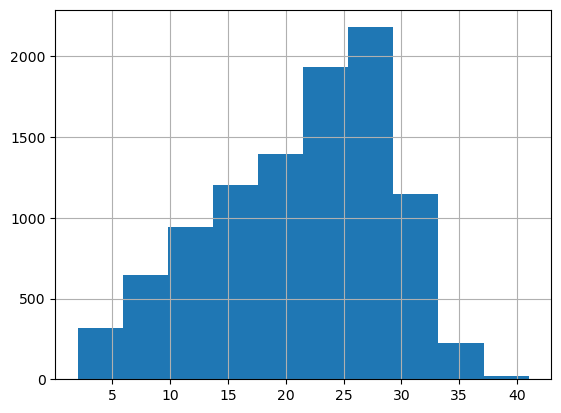

In [36]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
df['tweet_length'].hist()

In [134]:
def meanTweetEmbeddings(raw_tokens):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    n_embs = 0
    emb_sum = torch.zeros((embeddings.shape[1]))
    for i in range(min(embeddings.shape[0], 35)):
        if embeddings[i].abs().sum() > 0:
            n_embs += 1
            emb_sum += embeddings[i]
    if n_embs > 0:
        emb_avg = emb_sum / n_embs
    else:
        emb_avg = torch.zeros((embeddings.shape[1]))
    if np.any(np.isnan(emb_avg.numpy())):
        print(f"exists an nan: {emb_sum}")
    return emb_avg

X_int = df['tokens_raw'].apply(lambda x: meanTweetEmbeddings(x)).values
X_int[:5]

array([tensor([ 0.0837,  0.2356,  0.0932, -0.2021,  0.2486, -0.2921, -0.3439, -0.3056,
               -0.1537,  0.0545, -0.1713,  0.3776, -0.4873,  0.1572,  0.3986,  0.0401,
                0.0182,  0.3468, -0.4830, -0.4764, -0.1683,  0.3428,  0.5101,  0.1670,
                0.3129, -1.1873, -0.8067,  0.2145,  0.5646, -0.6136,  2.5591,  0.6210,
               -0.4014,  0.4220, -0.1392, -0.0400,  0.2742, -0.1185,  0.1463, -0.0762,
                0.0497, -0.0673, -0.1446,  0.2644,  0.2326,  0.1127,  0.0229, -0.3934,
               -0.0409,  0.3079])                                                     ,
       tensor([-1.5836e-01,  3.8903e-01, -1.2737e-02,  4.0904e-04,  1.6654e-01,
               -2.5873e-01, -6.0156e-01,  1.4093e-01, -2.3898e-01,  1.2685e-01,
               -3.4330e-01,  2.9059e-02, -2.4154e-01, -5.0291e-02,  1.9499e-01,
               -1.3800e-01,  1.7198e-01, -2.7018e-02, -7.1899e-01, -2.8644e-01,
               -3.4566e-01, -2.8031e-02,  4.0371e-01,  4.5659e-02,  2.

In [135]:
X = torch.stack(tuple(X_int))
X[:2]

tensor([[ 8.3735e-02,  2.3565e-01,  9.3152e-02, -2.0211e-01,  2.4863e-01,
         -2.9207e-01, -3.4392e-01, -3.0562e-01, -1.5370e-01,  5.4511e-02,
         -1.7127e-01,  3.7759e-01, -4.8734e-01,  1.5720e-01,  3.9859e-01,
          4.0137e-02,  1.8190e-02,  3.4679e-01, -4.8298e-01, -4.7640e-01,
         -1.6832e-01,  3.4277e-01,  5.1011e-01,  1.6704e-01,  3.1287e-01,
         -1.1873e+00, -8.0670e-01,  2.1450e-01,  5.6458e-01, -6.1361e-01,
          2.5591e+00,  6.2097e-01, -4.0142e-01,  4.2198e-01, -1.3919e-01,
         -3.9961e-02,  2.7416e-01, -1.1854e-01,  1.4631e-01, -7.6158e-02,
          4.9665e-02, -6.7306e-02, -1.4455e-01,  2.6445e-01,  2.3264e-01,
          1.1270e-01,  2.2937e-02, -3.9336e-01, -4.0882e-02,  3.0788e-01],
        [-1.5836e-01,  3.8903e-01, -1.2737e-02,  4.0904e-04,  1.6654e-01,
         -2.5873e-01, -6.0156e-01,  1.4093e-01, -2.3898e-01,  1.2685e-01,
         -3.4330e-01,  2.9059e-02, -2.4154e-01, -5.0291e-02,  1.9499e-01,
         -1.3800e-01,  1.7198e-01, -2

In [136]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'negative': 1, 'neutral': 2}


In [137]:
y[:10]

tensor([0, 0, 1, 1, 1, 1, 2, 1, 1, 0])

In [138]:
# Can be a good idea to occassionally check that the dims (or shapes) agree for the model inputs (X) and labels (y)
len(X) == len(y)

True

In [145]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))
        
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float

    def create_split(self, n, seed=1, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [146]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 8500


tensor([ 4.1335e-01,  3.9383e-01, -7.7336e-02,  8.8777e-02, -1.5469e-01,
        -4.2515e-01, -8.8961e-01,  2.4571e-02,  2.1848e-01, -5.2580e-01,
        -1.9226e-01, -2.1829e-02, -2.2161e-02, -4.8481e-01,  4.6226e-02,
         2.1966e-01, -2.2471e-01,  4.3616e-02, -5.1396e-01, -2.2075e-01,
         3.7680e-01,  3.6617e-01, -2.1132e-01,  5.6631e-02, -8.1064e-02,
        -1.3522e+00,  3.9988e-02,  3.6217e-02,  1.5300e-01, -4.1093e-01,
         2.8342e+00, -1.6130e-03, -1.9274e-01, -4.0728e-01,  3.1078e-01,
         5.4317e-02,  2.5612e-01, -5.9512e-02,  1.2397e-01,  1.7629e-01,
         1.3250e-01,  2.2146e-01,  2.3511e-01,  2.9826e-02, -3.0590e-01,
         9.8241e-02, -1.4583e-01, -3.8262e-01, -1.1806e-01,  1.5989e-01])

In [147]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [301]:
class AirlineTweetClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(AirlineTweetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 16)
        self.fc3 = nn.Linear(16, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [302]:
batch_size = 500
learning_rate = 0.01 #0.0075 # 0.005
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset.set_split('train')
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
dataset.set_split('val')
val_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [303]:
len(dataset[0]['x'])

50

In [304]:
model = AirlineTweetClassifier(len(dataset[0]['x']), 32, 3)

# define loss function and optimizer
#weights = 1 / torch.tensor([15.0, 65.0, 20.0])
loss_fun = nn.CrossEntropyLoss()#weights)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [305]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

In [306]:
n_train_batches = len(train_loader)
n_val_batches = len(val_loader)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    model.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(train_loader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (batch_i+1) % 200 == 0:
            print(f"    train batch {batch_i+1:3.0f} (of {n_train_batches:3.0f}) loss: {loss.item():.4f}")
        
    running_loss_train = running_loss_train / len(train_loader)

    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(val_loader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        
        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        if (i+1) % 50 == 0:
            print(f"    valid batch {i+1:3.0f} (of {n_val_batches:3.0f}) loss: {loss.item():.4f}")

    running_loss_val = running_loss_val / len(val_loader)
    print(f"Epoch {epoch+1} (of {num_epochs}): mean train loss = {running_loss_train:.4f}, mean val loss = {running_loss_val:.4f}")

    valid batch 200 (of   3) loss: 1.0107
    valid batch 200 (of   3) loss: 0.9937
    valid batch 200 (of   3) loss: 1.0187
Epoch 1 (of 200): mean train loss = 1.0759, mean val loss = 1.0077
    valid batch 200 (of   3) loss: 0.9251
    valid batch 200 (of   3) loss: 0.9269
    valid batch 200 (of   3) loss: 0.9047
Epoch 2 (of 200): mean train loss = 0.9777, mean val loss = 0.9189
    valid batch 200 (of   3) loss: 0.8720
    valid batch 200 (of   3) loss: 0.8909
    valid batch 200 (of   3) loss: 0.9142
Epoch 3 (of 200): mean train loss = 0.9058, mean val loss = 0.8924
    valid batch 200 (of   3) loss: 0.8848
    valid batch 200 (of   3) loss: 0.8737
    valid batch 200 (of   3) loss: 0.8448
Epoch 4 (of 200): mean train loss = 0.8866, mean val loss = 0.8678
    valid batch 200 (of   3) loss: 0.8807
    valid batch 200 (of   3) loss: 0.8306
    valid batch 200 (of   3) loss: 0.8862
Epoch 5 (of 200): mean train loss = 0.8720, mean val loss = 0.8658
    valid batch 200 (of   3) loss: 

Let's try a random forest model and see what happens when using embeddings as the feature (unfortunately, they don't quite have the same benefit)

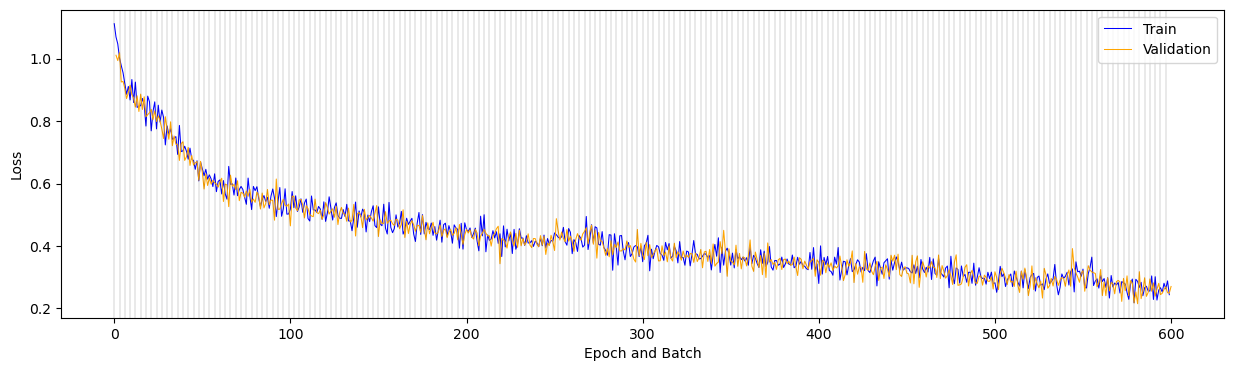

In [307]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [308]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in val_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(val_loader)} validation images): {100 * correct / total}%")
	 

Accuracy (on 3 validation images): 90.46666666666667%
